In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data vizualisation
import seaborn as sns # data vizualisation

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/data-science-bowl-2019/sample_submission.csv
/kaggle/input/data-science-bowl-2019/specs.csv
/kaggle/input/data-science-bowl-2019/train_labels.csv
/kaggle/input/data-science-bowl-2019/test.csv
/kaggle/input/data-science-bowl-2019/train.csv


In [4]:
root = '/kaggle/input/data-science-bowl-2019/'

print('Reading train.csv file ...', end='')
train = pd.read_csv(root + 'train.csv')  # training data
print(' Done!')

print('Reading train_labels.csv file ...', end='')
train_labels = pd.read_csv(root + 'train_labels.csv') 
print(' Done!')

print('Reading test.csv file ...', end='')
test = pd.read_csv(root + 'test.csv')
print(' Done!')

print('Reading specs.csv file ...', end='')
specs = pd.read_csv(root + 'specs.csv')
print(' Done!')

print('Reading sample_submission.csv file ...', end='')
sample_sub = pd.read_csv(root + 'sample_submission.csv')
print(' Done!')

print('All data imported')

Reading train.csv file ... Done!
Reading train_labels.csv file ... Done!
Reading test.csv file ... Done!
Reading specs.csv file ... Done!
Reading sample_submission.csv file ... Done!
All data imported


In [7]:
print('\t Shapes:')
print('train.csv \t - {} rows and {} columns'.format(train.shape[0], train.shape[1]))

print('train_labels.csv - {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))
print('test.csv \t - {} rows and {} columns'.format(test.shape[0], test.shape[1]))
print('specs.csv \t - {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))
print('sample_sub.csv \t - {} rows and {} columns'.format(sample_sub.shape[0], sample_sub.shape[1]))

	 Shapes:
train.csv 	 - 11341042 rows and 11 columns
train_labels.csv - 17690 rows and 7 columns
test.csv 	 - 1156414 rows and 11 columns
specs.csv 	 - 386 rows and 3 columns
sample_sub.csv 	 - 1000 rows and 2 columns


What variables do we have ?

In [8]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


These are the main data files which contain the gameplay events.

* `event_id` - Randomly generated unique identifier for the event type. Maps to `event_id` column in **specs** table.
* `game_session` - Randomly generated unique identifier grouping events within a single game or video play session.
* `timestamp` - Client-generated datetime 
* `event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: `event_count`, `event_code`, and `game_time`; otherwise fields are determined by the event type.
* `installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.
* `event_count` - Incremental counter of events within a game session (offset at 1). Extracted from `event_data`.
* `event_code` - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from `event_data`.
* `game_time` - Time in milliseconds since the start of the game session. Extracted from `event_data`.
* `title` - Title of the game or video.
* `type` - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
* `world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [17]:
pd.to_datetime(train['timestamp'].head())

0   2019-09-06 17:53:46.937000+00:00
1   2019-09-06 17:54:17.519000+00:00
2   2019-09-06 17:54:56.302000+00:00
3   2019-09-06 17:54:56.387000+00:00
4   2019-09-06 17:55:03.253000+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [10]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


**train_labels** is a transformation of the **train** data, on which we can train our models.
It seems that, in order to create a proper **train_labels** data frame, all the information we need to extract from **train** is in the `event_data` column.

The outcomes in this competition are grouped into 4 groups (labeled `accuracy_group` in the data):
* 3 : the assessment was solved on the first attempt     : `accuracy` = 1.0
* 2 : the assessment was solved on the second attempt    : `accuracy` = 0.5
* 1 : the assessment was solved after 3 or more attempts : 0 < `accuracy` $\leq$ 0.5
* 0 : the assessment was never solved                    : `accuracy` = 0.0


What does the submission should look like:

In [11]:
sample_sub.head()

,installation_id,accuracy_group
0,00abaee7,3
1,01242218,3
2,017c5718,3
3,01a44906,3
4,01bc6cb6,3


Because the training data is so large, we will take a random sample of it for plotting. Since we are doing this at random it will speed up the time it takes to plot, and should still give us a a good view of the data's format.

In [76]:
train_ = train.sample(1000000)

Now we have to find how to create the variables `num_correct` and `num_incorrect` in order to create `accuracy` and then `accuracy_group`.

For that, whenever ***"correct":true*** appears in the column `event_data`, it means that that player succeed the current event (recognizable by `event_id`). In the same way, whenever ***"correct":false*** appears in the column `event_data` it means that that player failed the current event.

So, we're looking for the number of appearances of ***"correct":true*** and ***"correct":false*** in the same `game_session`.

In [99]:
num_correct = train_[train_['event_data'].str.contains('correct":true')].groupby('game_session').count().iloc[:,0]
num_incorrect = train_[train_['event_data'].str.contains('correct":false')].groupby('game_session').count().iloc[:,0]

In [110]:
print('\t Lengths:')
print('num_correct   - {} rows'.format(num_correct.shape[0]))
print('num_incorrect - {} rows'.format(num_incorrect.shape[0]))

	 Shapes:
num_correct   - 25206 rows
num_incorrect - 15820 rows


/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


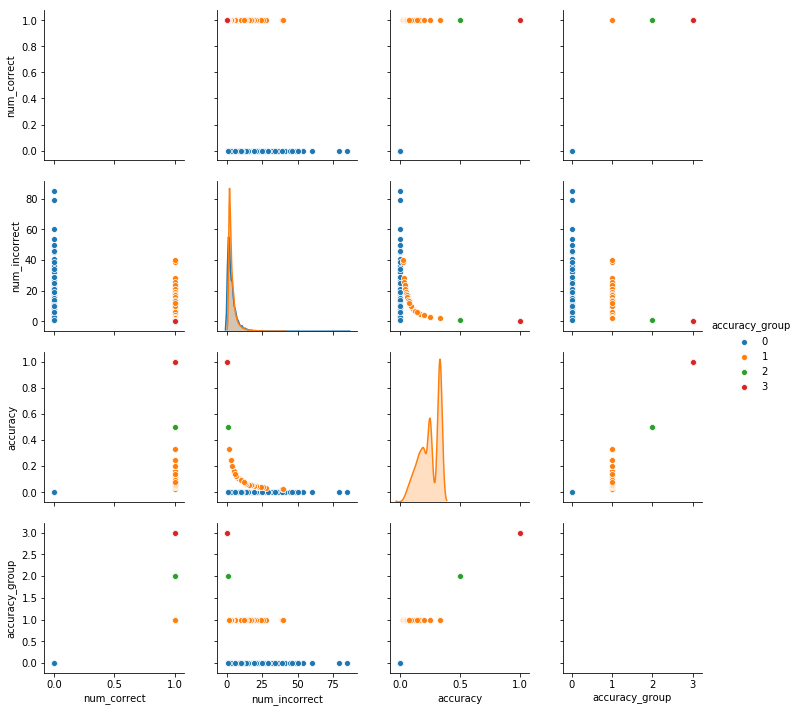

In [13]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()